<a href="https://colab.research.google.com/github/maiaufrrj/superstore_data/blob/main/modelo_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!pip install fbprophet
#!pip install pystan
#!pip install --upgrade plotly
#! pip install statsmodels

In [3]:
# importar os pacotes necessários
import pandas as pd
import plotly.express as px
import numpy as np

#importar o arquivo csv do meu repositório público no github 
dataset='https://raw.githubusercontent.com/maiaufrrj/superstore_data/main/superstore_dataset2011-2015.csv'
df = pd.read_csv(dataset, encoding= 'unicode_escape')

# visualizar início dos dados
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,NaN,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,NaN,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [4]:
#criando dicionário para entender cada recurso disponível e posteriormente modificar dataframe
columns = {'Row ID':'id_linha',
           'Order ID': 'id_pedido', 
           'Order Date': 'data_pedido',
           'Ship Date': 'data_envio',
           'Ship Mode': 'modalidade_frete',
           'Customer ID': 'id_cliente',
           'Customer Name': 'cliente',
           'Segment': 'segmento',
           'City': 'cidade',
           'State': 'estado',
           'Country': 'país',
           'Postal Code': 'cod_postal',
           'Market': 'mercado',
           'Region': 'regiao',
           'Product ID': 'id_produto',
           'Category': 'categoria_produto',
           'Sub-Category': 'subcategoria_produto',
           'Product Name': 'produto',
           'Sales': 'vendas',
           'Quantity': 'quantidade',
           'Discount': 'desconto',
           'Profit': 'lucro',
           'Shipping Cost': 'custo_envio',
           'Order Priority': 'prioridade'
           }
#trocando nomes das colunas e selecionando coluna de índice
df=df.rename(columns=columns).set_index('id_pedido')   

In [5]:
df.head()

,id_linha,data_pedido,data_envio,modalidade_frete,id_cliente,cliente,segmento,cidade,estado,país,cod_postal,mercado,regiao,id_produto,categoria_produto,subcategoria_produto,produto,vendas,quantidade,desconto,lucro,custo_envio,prioridade
id_pedido,,,,,,,,,,,,,,,,,,,,,,,
AG-2011-2040,42433,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
IN-2011-47883,22253,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
HU-2011-1220,48883,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,NaN,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
IT-2011-3647632,11731,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,NaN,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
IN-2011-47883,22255,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [6]:
#plano amostral -- bootstrap (amostra aleatória simples com reposição)
#referencia: 
#SCIENTIFIC RESEARCH METHODOLOGY: GUIDELINES FOR SIZE SAMPLE CALCULATION
#Mauro José FONTELLES, Marilda Garcia SIMÕES, Jairo Cunha de ALMEIDA e Renata Garcia Simões FONTELLES
#http://files.bvs.br/upload/S/0101-5907/2010/v24n2/a2125.pdf

erro_amostral=0.02
n0=1/(erro_amostral**2)
n=(df.shape[0]*n0)/(df.shape[0]+n0)
print('Para uma população de '+ str(df.shape[0]) + ' será necessária uma amostra de ' + str(round(n,0)) + ' registros')

Para uma população de 51290 será necessária uma amostra de 2384.0 registros


In [7]:
tamanho_populacao = df.shape[0]
tamanho_amostra = n

amostra1 = df.sample(n=int(tamanho_amostra), random_state=0)
amostra1 =amostra1[['vendas','custo_envio']]

amostra2 = df.sample(n=int(tamanho_amostra), random_state=42)
amostra2 =amostra2[['vendas','desconto']]

In [8]:
import plotly.express as px
fig1 = px.histogram(amostra1, x='custo_envio', y='vendas', nbins=20, histfunc='sum')
fig2 = px.histogram(amostra2, x='desconto', y='vendas', nbins=20, histfunc='sum')
fig1.show()
fig2.show()

In [9]:
df['vendas_unit']=df['vendas']/df['quantidade']
df['custo_envio_unit']=df['custo_envio']/df['quantidade']
df['lucro_unit']=df['lucro']/df['quantidade']
df.sample(50)

,id_linha,data_pedido,data_envio,modalidade_frete,id_cliente,cliente,segmento,cidade,estado,país,cod_postal,mercado,regiao,id_produto,categoria_produto,subcategoria_produto,produto,vendas,quantidade,desconto,lucro,custo_envio,prioridade,vendas_unit,custo_envio_unit,lucro_unit
id_pedido,,,,,,,,,,,,,,,,,,,,,,,,,,
ES-2014-3147119,12596,4/4/2014,8/4/2014,Standard Class,IM-15055,Ionia McGrath,Consumer,Tourcoing,Nord-Pas-de-Calais,France,NaN,EU,Central,OFF-PA-10004470,Office Supplies,Paper,"Green Bar Cards & Envelopes, Recycled",96.60000,2,0.000,10.62000,13.47,High,48.30000,6.735000,5.31000
CA-2014-4080,50009,17-11-2014,23-11-2014,Standard Class,SR-10425,Sharelle Roach,Home Office,London,Ontario,Canada,NaN,Canada,Canada,OFF-BIN-10000901,Office Supplies,Art,"Binney & Smith Pens, Water Color",60.48000,4,0.000,21.72000,6.63,Low,15.12000,1.657500,5.43000
ES-2014-5666077,15231,3/2/2014,7/2/2014,Standard Class,HD-14785,Harold Dahlen,Home Office,Granada,Andalusía,Spain,NaN,EU,South,TEC-PH-10004910,Technology,Phones,"Samsung Signal Booster, Full Size",248.18400,2,0.100,104.78400,21.88,Medium,124.09200,10.940000,52.39200
IZ-2013-9470,50911,12/4/2013,12/4/2013,Same Day,JH-6180,Justin Hirsh,Consumer,Baghdad,Baghdad,Iraq,NaN,EMEA,EMEA,OFF-FEL-10004224,Office Supplies,Storage,"Fellowes Trays, Wire Frame",225.84000,4,0.000,56.40000,23.25,Medium,56.46000,5.812500,14.10000
ID-2013-34177,27383,16-05-2013,22-05-2013,Standard Class,BK-11260,Berenike Kampe,Consumer,Ulsan,Ulsan,South Korea,NaN,APAC,North Asia,FUR-TA-10000147,Furniture,Tables,"Lesro Coffee Table, Rectangular",99.82800,2,0.800,-344.41200,7.72,Medium,49.91400,3.860000,-172.20600
IS-2013-5600,41375,31-12-2013,4/1/2014,Standard Class,HA-4920,Helen Andreada,Consumer,Jerusalem,Jerusalem,Israel,NaN,EMEA,EMEA,TEC-CAN-10003392,Technology,Copiers,"Canon Copy Machine, Color",263.58000,1,0.000,65.88000,32.17,High,263.58000,32.170000,65.88000
CA-2014-167899,32286,22-05-2014,27-05-2014,Standard Class,JG-15805,John Grady,Corporate,Auburn,New York,United States,13021.0,US,East,OFF-AR-10001988,Office Supplies,Art,Bulldog Table or Wall-Mount Pencil Sharpener,17.97000,3,0.000,5.21130,0.63,Medium,5.99000,0.210000,1.73710
CA-2014-128363,39199,14-08-2014,19-08-2014,Standard Class,DC-12850,Dan Campbell,Consumer,Memphis,Tennessee,United States,38109.0,US,South,OFF-EN-10003845,Office Supplies,Envelopes,Colored Envelopes,14.76000,5,0.200,4.79700,0.92,Medium,2.95200,0.184000,0.95940
CA-2012-158421,37480,21-09-2012,26-09-2012,Standard Class,GB-14575,Giulietta Baptist,Consumer,Columbia,South Carolina,United States,29203.0,US,South,OFF-ST-10004186,Office Supplies,Storage,"Stur-D-Stor Shelving, Vertical 5-Shelf: 72""H x...",887.84000,8,0.000,17.75680,68.78,Medium,110.98000,8.597500,2.21960


In [10]:
fig1 = px.histogram(df, x='mercado', y='vendas', histfunc='sum').update_xaxes(categoryorder='total descending')
fig1.show()

In [10]:
fig2 = px.histogram(df, x='mercado', y="custo_envio", histfunc='sum').update_xaxes(categoryorder='total descending')
fig2.show()

In [10]:
#verificando os 20 países que somaram as maiores vendas
topVendas_20_paises = df.groupby(['país']).agg({'vendas':sum})
topVendas_20_paises.sort_values(by='vendas', ascending=False, inplace=True)
topVendas_20_paises.style.format("{:.1f}")
topVendas_20_paises = topVendas_20_paises[:20]

fig2 = px.histogram(topVendas_20_paises, x=topVendas_20_paises.index, y='vendas', histfunc='sum').update_xaxes(categoryorder='total descending')
fig2.show()

In [10]:
#verificando os 20 países que somaram os maiores lucros
topLucro_20_paises = df.groupby(['mercado']).agg({'lucro':sum})
topLucro_20_paises.sort_values(by='lucro', ascending=False, inplace=True)
topLucro_20_paises.style.format("{:.1f}")
topLucro_20_paises = topLucro_20_paises[:20]

fig3 = px.histogram(topLucro_20_paises, x=topLucro_20_paises.index, y='lucro', histfunc='sum').update_xaxes(categoryorder='total descending')
fig3.show()

In [10]:
#verificando os 20 países que somaram os menores lucros
bottomLucro_20_paises = df.groupby(['país']).agg({'lucro':sum})
bottomLucro_20_paises.sort_values(by='lucro', ascending=True, inplace=True)
bottomLucro_20_paises.style.format("{:.1f}")
bottomLucro_20_paises = bottomLucro_20_paises[:20]

fig3 = px.histogram(bottomLucro_20_paises, x=bottomLucro_20_paises.index, y='lucro', histfunc='sum').update_xaxes(categoryorder='total ascending')
fig3.show()

In [10]:
import plotly.io as pio
aggs = ["count","sum","avg","median","mode","rms","stddev","min","max","first","last"]

agg = []
agg_func = []
for i in range(0, len(aggs)):
    agg = dict(
        args=['transforms[0].aggregations[0].func', aggs[i]],
        label=aggs[i],
        method='restyle'
    )
    agg_func.append(agg)

data = [dict(
  type = 'choropleth',
  locationmode = 'country names',
  locations = df['país'],
  z = df['vendas'],
  autocolorscale = False,
  colorscale = 'Portland',
  reversescale = False,
  transforms = [dict(
    type = 'aggregate',
    groups = df['país'],
    aggregations = [dict(
        target = 'z', func = 'sum', enabled = True)
    ]
  )]
)]

layout = dict(
  title = '<b>Agregação de Vendas</b><br>escolha o tipo de agregação',
  xaxis = dict(title = 'Subject'),
  yaxis = dict(title = 'Score', range = [0,22]),
  height = 600,
  width = 900,
  updatemenus = [dict(
        x = 0.85,
        y = 1.15,
        xref = 'paper',
        yref = 'paper',
        yanchor = 'top',
        active = 1,
        showactive = False,
        buttons = agg_func
  )]
)

fig_dict = dict(data=data, layout=layout)

pio.show(fig_dict, validate=False)

In [10]:
import plotly.io as pio
aggs = ["count","sum","avg","median","mode","rms","stddev","min","max","first","last"]

agg = []
agg_func = []
for i in range(0, len(aggs)):
    agg = dict(
        args=['transforms[0].aggregations[0].func', aggs[i]],
        label=aggs[i],
        method='restyle'
    )
    agg_func.append(agg)

data = [dict(
  type = 'choropleth',
  locationmode = 'country names',
  locations = df['país'],
  z = df['lucro'],
  autocolorscale = False,
  colorscale = 'Portland',
  reversescale = False,
  transforms = [dict(
    type = 'aggregate',
    groups = df['país'],
    aggregations = [dict(
        target = 'z', func = 'sum', enabled = True)
    ]
  )]
)]

layout = dict(
  title = '<b>Agregação de Lucro</b><br>escolha o tipo de agregação',
  xaxis = dict(title = 'Subject'),
  yaxis = dict(title = 'Score', range = [0,22]),
  height = 600,
  width = 900,
  updatemenus = [dict(
        x = 0.85,
        y = 1.15,
        xref = 'paper',
        yref = 'paper',
        yanchor = 'top',
        active = 1,
        showactive = False,
        buttons = agg_func
  )]
)

fig_dict = dict(data=data, layout=layout)

pio.show(fig_dict, validate=False)

In [10]:
#criar dataset resumido em vendas mensais
df2=df
df2.index = pd.to_datetime(df2['data_pedido'])

df2['mes_ano'] = pd.to_datetime(df2['data_pedido']).apply(lambda x: '{month}-{year}'.format(month=x.month, year=x.year))

df_vendas = df2.groupby('mes_ano')['vendas'].sum()
df_vendas.to_frame()

df_vendas = pd.DataFrame({'mes_ano':df_vendas.index, 'vendas':df_vendas.values})
df_vendas['ano'] = pd.DatetimeIndex(df_vendas['mes_ano']).year
df_vendas['mes'] = pd.DatetimeIndex(df_vendas['mes_ano']).month

#último dia do mês
from pandas.tseries.offsets import MonthEnd
df_vendas['ultimo_dia_mes'] = pd.to_datetime(df_vendas['mes_ano']) + MonthEnd(1)

df_vendas = df_vendas.sort_values(['ano', 'mes'], ascending = (True, True))
df_vendas.set_index('mes_ano')
#df_vendas.head(50)

In [10]:
#gráfico para visualizar evolução de vendas
fig = px.line(df_vendas, x='ultimo_dia_mes', y="vendas")
fig.show()

In [10]:
#Teste de Dickey Fuller Aumentado - Verificando Estacionariedade
from statsmodels.tsa.stattools import adfuller
X = df_vendas['vendas'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [10]:
train_size = int(0.85 * len(df_vendas))
test_size = len(df_vendas) - train_size

univariate_df = df_vendas[['ultimo_dia_mes', 'vendas']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

In [10]:
#https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
#https://towardsdatascience.com/facebook-prophet-for-time-series-forecasting-in-python-part1-d9739cc79b1d
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
import math

#instanciando e treinando modelo
model = Prophet(changepoint_prior_scale= 0.01, seasonality_prior_scale= 1.0) #hiperparâmetros ajustados
model.fit(train)
future = model.make_future_dataframe(periods=12, freq='m')

# Conjunto de Previsão
y_pred = model.predict(future)

from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, y_pred)

In [ ]:
componentes = model.plot_components(y_pred)

In [ ]:
#validação cruzada
#https://facebook.github.io/prophet/docs/diagnostics.html
from fbprophet.diagnostics import cross_validation, performance_metrics
df_vendas_cv = cross_validation(model, initial='913 days', period='60 days', horizon = '30 days')

In [ ]:
relatorio_cv = performance_metrics(df_vendas_cv)
relatorio_cv.sort_values(by='mape').head(50)

In [ ]:
relatorio_cv['mape'].mean()

MAPE: Erro Absoluto Médio Percentual

# 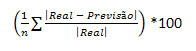

In [ ]:
#tunando hiperparâmetros do modelo
import itertools
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Gerando combinação de parâmetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # guardar MAPEs para cada parâmetro aqui

# Usar validação cruzada para avaliar todos os parâmetros
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Encontrar melhores parâmetros
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

In [ ]:
tuning_results

In [ ]:
best_params = all_params[np.argmin(mapes)]
print(best_params)